<a href="https://colab.research.google.com/github/julycapstone2020/Pneumonia-Detection-Challenge/blob/development/notebook/Pneumonia_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Pneumonia Detection 

This notebook build an end-to-end build a pneumonia detection system, to locate the position of inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting `lung opacities`, there are lung opacities that are not pneumonia related.

## 1. Problem

To locate the position of inflammation in an image.

## 2. Data

In the data, some of these are labeled `Not Normal No Lung Opacity`.This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: -Medical images are stored in a special format called DICOM files `(*.dcm)`. They contain a combination of header metadata as well as underlying raw image arrays for pixel data.Details about the data and dataset files are given in below link,

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

### Pre-Processing, Data Visualization, EDA 

* Exploring the given Data files, classes and images of different classes.
* Dealing with missing values
* Visualizationof different classes 
* Analysis from the visualizationof different classes


### Model Building 

* Building a pneumonia detection model starting from basic CNN and then improving upon it.
* Train the model
* To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch


### Test the Model, Fine-tuning and Repeat

* Test the model and report as per evaluation metrics
* Try different models
* Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them
* Report evaluation metrics for these modelsalong with your observation on how changing different hyper parameters leads to change in the final evaluation metric.

## 3. Evaluation



## 4. Features



In [2]:
#! pip install pydicom

In [3]:
 #!unzip "/content/drive/My Drive/Pneumonia Detection/rsna-pneumonia-detection-challenge.zip" -d "drive/My Drive/Pneumonia Detection/"

Get our workspace ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Make sure we're using GPU

In [4]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("TF version", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TF version 2.2.0
TF Hub version: 0.8.0
GPU available (YESSSSS!!!!!)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# To save your the installed configuration to your Google Drive
# !pip freeze --local > drive/My\ Drive/Pneumonia\ Detection/requirements.txt

In [7]:
# To restore out installed configuration from the requirement.txt
!pip install --upgrade --force-reinstall `cat drive/My\ Drive/Pneumonia\ Detection/requirements.txt`

     |████████████████████████████████| 35.5MB 88kB/s 


## Getting our data ready 

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. (numerical representations).

Let's start by accessing our data and checking out the labels.

In [8]:
# Checkout the labels of our data

PROJECT_DIR = "drive/My Drive/Pneumonia Detection/"

class_info_df = pd.read_csv(PROJECT_DIR + 'stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PROJECT_DIR +'stage_2_train_labels.csv')

print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [9]:
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [10]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Create a function to find the missing data in the dataset

In [11]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

In [12]:
# Missing data from train labels dataset
missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [13]:
# Missing data from class dataset
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


Lets find out how many are labeled `Not Normal, No Lung Opacity and Normal`.

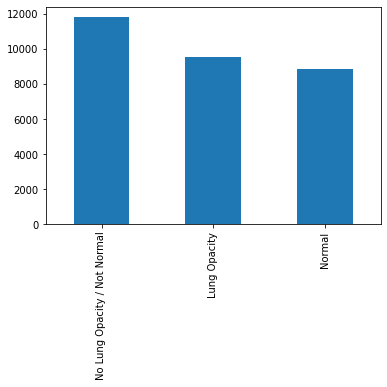

In [14]:
class_info_df['class'].value_counts().plot.bar(figsize=(6,4))

### Merge both `class info` and `train labels` into one dataset

In [15]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [16]:
train_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [17]:
train_class_df.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
class         object
dtype: object

### Let's view heat map of the features

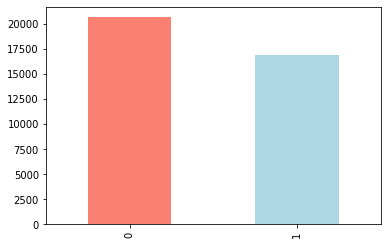

In [18]:
# Plot the value counts with a bar graph
train_class_df['Target'].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

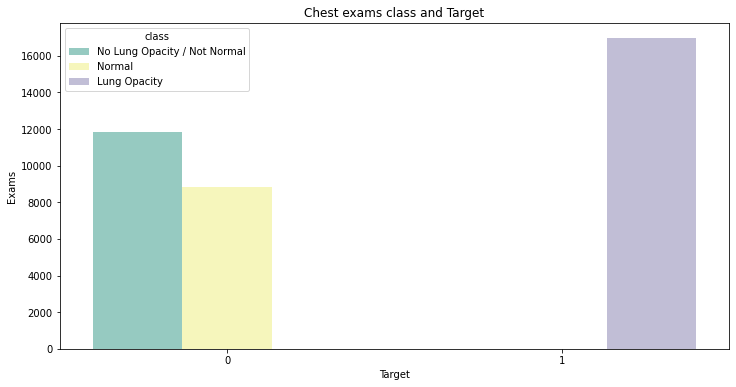

In [19]:

fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

<Figure size 432x288 with 0 Axes>

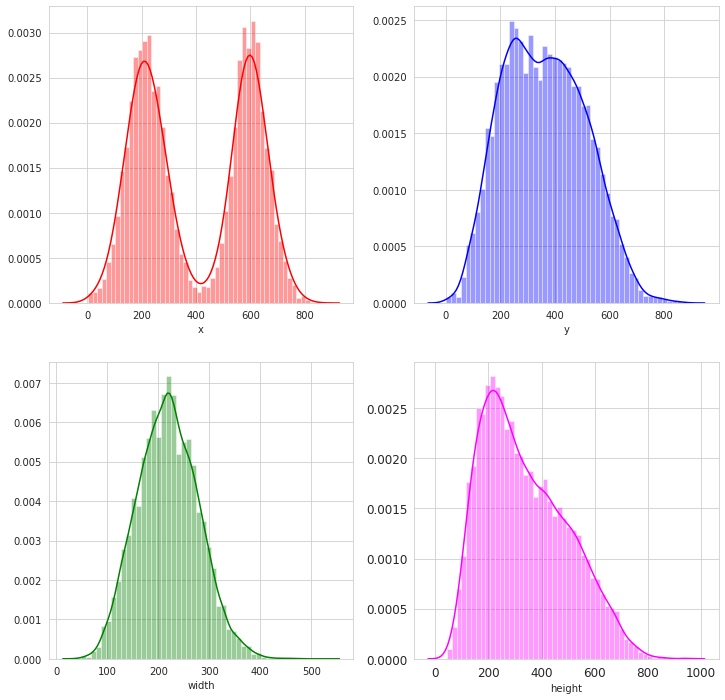

In [20]:
# Check out the distrubution for the target where target is _samples_1
target_samples_1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target_samples_1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target_samples_1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target_samples_1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target_samples_1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

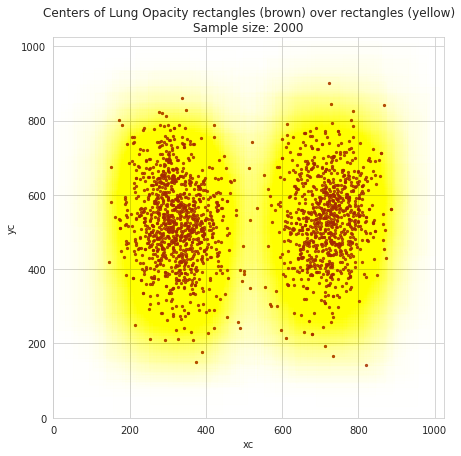

In [21]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1,1,figsize=(7,7))
target_samples_2 = target_samples_1.sample(2000)
target_samples_2['xc'] = target_samples_2['x'] + target_samples_2['width'] / 2
target_samples_2['yc'] = target_samples_2['y'] + target_samples_2['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_samples_2.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_samples_2.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [26]:
import os
image_sample_path = os.listdir(PROJECT_DIR + "stage_2_train_images")[:5]
print(image_sample_path)

['fbf35b8f-626d-4737-b152-d1f65a64080e.dcm', 'fc8234d8-06fe-47f3-8fdd-cf5b01fb721c.dcm', 'fc74ff08-3d2e-497f-8068-a7c1482cc8a3.dcm', 'fcae3037-2029-4c72-9204-cb11b4113e1a.dcm', 'fc0e9c65-29d3-4950-9565-b8f44f7f5dca.dcm']


In [60]:
image_train_path = PROJECT_DIR +"stage_2_train_images"

image_test_path = PROJECT_DIR +"stage_2_test_images"

print("Number of images in train set:", len(os.listdir(image_train_path)),
      "\nNumber of images in test set:", len(os.listdir(image_test_path)))

Number of images in train set: 26684 
Number of images in test set: 3000


In [28]:
print("Unique patientId in  train_class_df: ", train_class_df.patientId.nunique())

Unique patientId in  train_class_df:  26684


### Read DICOM Metadata

In [29]:
## DICOM METADATA
import pydicom as dcm
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID +'.dcm'
dicom_file_path = os.path.join(PROJECT_DIR +"stage_2_train_images/", samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [30]:


def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PROJECT_DIR +"stage_2_train_images/", patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

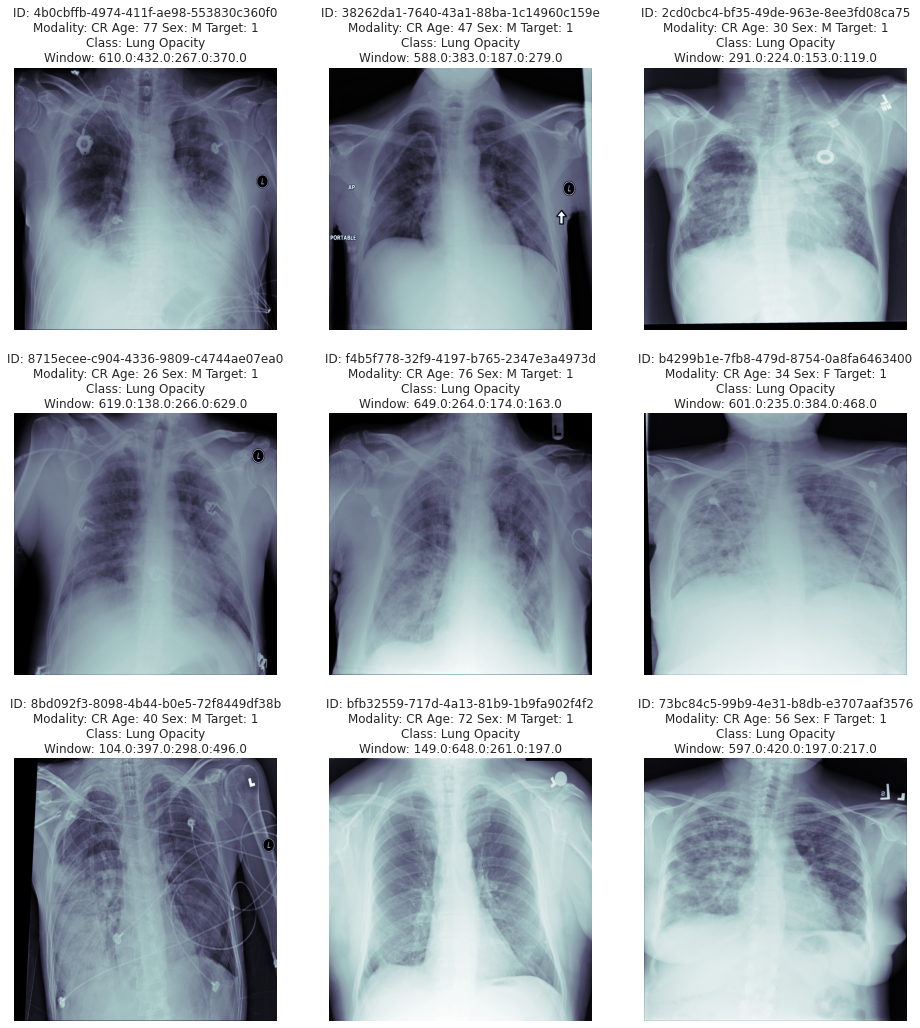

In [31]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [32]:
from tqdm.notebook import tqdm
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        #imagePath = os.path.join(img_path,data_path,img_name)
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])

In [33]:
# process_dicom_data(train_class_df, PROJECT_DIR +"stage_2_train_images")

In [34]:
#print(train_class_df.columns)

### Load already processed train and test data from excel files

In [35]:
train_df = pd.read_excel(PROJECT_DIR + 'final_train_class_df.xlsx')
test_df = pd.read_excel(PROJECT_DIR +'final_test_class_df.xlsx')

In [36]:
train_df.head()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37629 entries, 0 to 37628
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patientId         37629 non-null  object 
 1   x                 16957 non-null  float64
 2   y                 16957 non-null  float64
 3   width             16957 non-null  float64
 4   height            16957 non-null  float64
 5   Target            37629 non-null  int64  
 6   class             37629 non-null  object 
 7   Modality          37629 non-null  object 
 8   PatientAge        37629 non-null  int64  
 9   PatientSex        37629 non-null  object 
 10  BodyPartExamined  37629 non-null  object 
 11  ViewPosition      37629 non-null  object 
 12  ConversionType    37629 non-null  object 
 13  Rows              37629 non-null  int64  
 14  Columns           37629 non-null  int64  
 15  PixelSpacing      37629 non-null  float64
dtypes: float64(5), int64(4), object(7)
memor

In [38]:
test_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


## Fill missing values 

### Fill numerical missing values first

In [39]:
for label, content in train_df.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

x
y
width
height
Target
PatientAge
Rows
Columns
PixelSpacing


In [40]:
# Check for which numeric columns have null value
for label, content in train_df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

x
y
width
height


In [41]:
# Fill numeric rows with the zero
for label, content in train_df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            train_df[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            train_df[label] = content.fillna(0)

In [42]:
train_df.Rows.fillna(0, inplace=True)
train_df.Columns.fillna(0, inplace=True)

In [43]:
# Check if there are any missing numberic values
train_df.isna().sum()

patientId            0
x                    0
y                    0
width                0
height               0
Target               0
class                0
Modality             0
PatientAge           0
PatientSex           0
BodyPartExamined     0
ViewPosition         0
ConversionType       0
Rows                 0
Columns              0
PixelSpacing         0
x_is_missing         0
y_is_missing         0
width_is_missing     0
height_is_missing    0
dtype: int64

In [44]:
# Check first 5 datapoints
train_df.head()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,x_is_missing,y_is_missing,width_is_missing,height_is_missing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,True,True,True,True
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,True,True,True,True
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,True,True,True,True
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,True,True,True,True
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,False,False,False,False


### Filling and turning categorical variables into numbers

In [45]:
# Check for columns which aren't numeric
for label, content in train_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

patientId
class
Modality
PatientSex
BodyPartExamined
ViewPosition
ConversionType


In [46]:
# Check for which non numeric columns have null value
for label, content in train_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [47]:
pd.Categorical(train_df["class"])

[No Lung Opacity / Not Normal, No Lung Opacity / Not Normal, No Lung Opacity / Not Normal, Normal, Lung Opacity, ..., Normal, Lung Opacity, Lung Opacity, Lung Opacity, Lung Opacity]
Length: 37629
Categories (3, object): [Lung Opacity, No Lung Opacity / Not Normal, Normal]

In [48]:
# Find the unique patient ids
len(train_df.patientId.unique())

26684

### Pneumonia Frequency according to sex

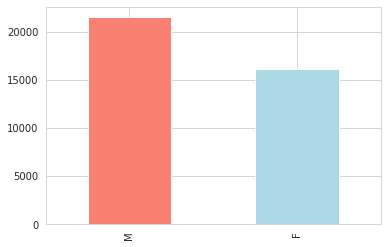

In [49]:
# Plot the value counts with a bar graph
train_df['PatientSex'].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [50]:
# Compare target column with sex column
pd.crosstab(train_df.Target, train_df.PatientSex)

PatientSex,F,M
Target,,
0,9016,11656
1,7115,9842


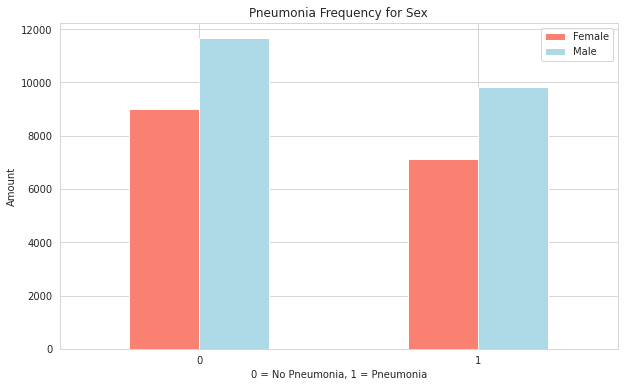

In [51]:
# Create a plot
pd.crosstab(train_df.Target, train_df.PatientSex).plot(kind="bar",
                                    figsize=(10,6),
                                    color=["salmon", "lightblue"]
                            );
plt.title("Pneumonia Frequency for Sex")
plt.xlabel("0 = No Pneumonia, 1 = Pneumonia")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

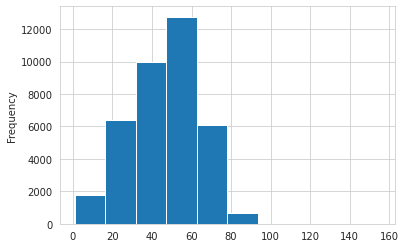

In [52]:
train_df['PatientAge'].plot.hist()

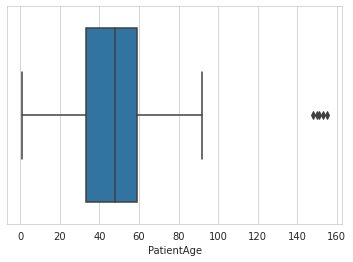

In [53]:
sns.boxplot(x=train_df['PatientAge'], data=train_df)

In [61]:
# Drop Rows and Columns as it is not required. 
train_df.drop(['Rows','Columns'], axis=1, inplace=True)

Correlation between independent variables
We'll compare all of the independent variables in one hit.

This may give an idea of which independant variables may or may not have an impact on target

In [62]:
# Make a correlation matrix

train_df.corr()

,x,y,width,height,Target,PatientAge,PixelSpacing,x_is_missing,y_is_missing,width_is_missing,height_is_missing
x,1.000000,0.807597,0.819776,0.772164,0.865209,-0.022905,0.006313,-0.865209,-0.865209,-0.865209,-0.865209
y,0.807597,1.000000,0.875852,0.746893,0.939901,-0.005794,0.022915,-0.939901,-0.939901,-0.939901,-0.939901
width,0.819776,0.875852,1.000000,0.921998,0.955316,-0.014526,0.021655,-0.955316,-0.955316,-0.955316,-0.955316
height,0.772164,0.746893,0.921998,1.000000,0.885099,-0.010910,0.027020,-0.885099,-0.885099,-0.885099,-0.885099
Target,0.865209,0.939901,0.955316,0.885099,1.000000,-0.018668,0.024499,-1.000000,-1.000000,-1.000000,-1.000000
PatientAge,-0.022905,-0.005794,-0.014526,-0.010910,-0.018668,1.000000,0.007129,0.018668,0.018668,0.018668,0.018668
PixelSpacing,0.006313,0.022915,0.021655,0.027020,0.024499,0.007129,1.000000,-0.024499,-0.024499,-0.024499,-0.024499
x_is_missing,-0.865209,-0.939901,-0.955316,-0.885099,-1.000000,0.018668,-0.024499,1.000000,1.000000,1.000000,1.000000
y_is_missing,-0.865209,-0.939901,-0.955316,-0.885099,-1.000000,0.018668,-0.024499,1.000000,1.000000,1.000000,1.000000
width_is_missing,-0.865209,-0.939901,-0.955316,-0.885099,-1.000000,0.018668,-0.024499,1.000000,1.000000,1.000000,1.000000


(11.5, -0.5)

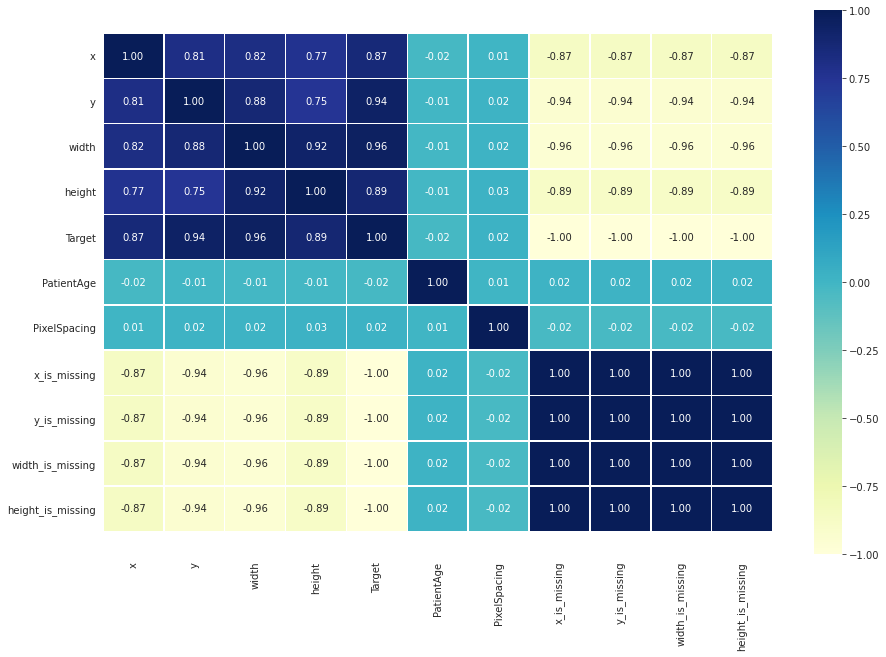

In [63]:
# Let's make our correlation matrix a little prettier
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu");
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [64]:
train_df.drop_duplicates(subset=['patientId', 'x', 'y', 'width', 'height' ], keep=False, inplace=True)

train_df.head()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,PixelSpacing,x_is_missing,y_is_missing,width_is_missing,height_is_missing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,0.143,True,True,True,True
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,0.194,True,True,True,True
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,0.168,True,True,True,True
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,CR,28,M,CHEST,PA,WSD,0.143,True,True,True,True
8,00569f44-917d-4c86-a842-81832af98c30,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,54,M,CHEST,AP,WSD,0.139,True,True,True,True


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23286 entries, 0 to 37624
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientId          23286 non-null  object 
 1   x                  23286 non-null  float64
 2   y                  23286 non-null  float64
 3   width              23286 non-null  float64
 4   height             23286 non-null  float64
 5   Target             23286 non-null  int64  
 6   class              23286 non-null  object 
 7   Modality           23286 non-null  object 
 8   PatientAge         23286 non-null  int64  
 9   PatientSex         23286 non-null  object 
 10  BodyPartExamined   23286 non-null  object 
 11  ViewPosition       23286 non-null  object 
 12  ConversionType     23286 non-null  object 
 13  PixelSpacing       23286 non-null  float64
 14  x_is_missing       23286 non-null  bool   
 15  y_is_missing       23286 non-null  bool   
 16  width_is_missing   232

### Getting images and their labels

Let's get a list of all our images file parameters.


In [92]:
# Create pathnames from image Patient ID's

filenames = [image_train_path + "/" + pid + ".dcm" for pid in train_df.loc[train_df.Target == 1]['patientId']]

# Check the first 10
filenames[:10]

['drive/My Drive/Pneumonia Detection/stage_2_train_images/0100515c-5204-4f31-98e0-f35e4b00004a.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/01adfd2f-7bc7-4cef-ab68-a0992752b620.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/01cd2ba5-2baf-44b2-bf15-ee57e1ea4599.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/01dc817c-3cfa-49fe-8662-518edc30652a.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/02285fa4-35b7-4af6-b88f-3cac45a7f5c8.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/02e93c9a-c063-4bf2-9fa1-cb26692d58f8.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/03d92597-3e33-4fdf-8db5-a27cf5b8d3eb.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/049d7317-5a8b-4fc4-b81f-159fe6b45a92.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/04a6aa6d-bd6d-48b1-822b-21b81c4bdf3a.dcm',
 'drive/My Drive/Pneumonia Detection/stage_2_train_images/04d59a79-e659-49ca-8790-511f89ac3

In [98]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir(image_train_path)) == len(filenames):
  print('Filenames match actual amount of files !!!')
else:
  print(f"Actual files {len(os.listdir(image_train_path))} != Filenames {len(filenames)}")
  print("Filesnames do not match actual amount of files, check the target directory")

Actual files 26684 != Filenames 2614
Filesnames do not match actual amount of files, check the target directory


Since we've now got our training image filepaths in a list, let's prepare our labels

In [93]:
import numpy as np
labels = train_df.loc[train_df.Target == 1].iloc[:,1:5].values.tolist()
labels[:10]

[[703.0, 416.0, 84.0, 77.0],
 [225.0, 415.0, 98.0, 101.0],
 [664.0, 380.0, 141.0, 330.0],
 [368.0, 677.0, 101.0, 139.0],
 [744.0, 207.0, 103.0, 194.0],
 [185.0, 232.0, 122.0, 284.0],
 [591.0, 242.0, 187.0, 333.0],
 [645.0, 378.0, 199.0, 96.0],
 [349.0, 735.0, 173.0, 172.0],
 [638.0, 535.0, 166.0, 145.0]]

In [94]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filesnames!')
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filesnames!


## Creating our own validataion set

since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [96]:
# Setup X & y variables
X = filenames
y = labels

In [97]:
len(filenames)

2614

We're going to start off experimenting with ~1000 images and increase as needed.

In [58]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [102]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [103]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Pneumonia Detection/stage_2_train_images/06ac3c8c-cd1f-4e10-ac24-4cb4f3ab1243.dcm',
  'drive/My Drive/Pneumonia Detection/stage_2_train_images/44da3869-4815-4f7c-9350-a396d9961443.dcm',
  'drive/My Drive/Pneumonia Detection/stage_2_train_images/5c08d026-9acd-40ab-abb9-141bc3b6afbd.dcm',
  'drive/My Drive/Pneumonia Detection/stage_2_train_images/48235c65-9a41-426c-b695-a01590d15333.dcm',
  'drive/My Drive/Pneumonia Detection/stage_2_train_images/695e33f8-31d1-467e-add2-f05041880b28.dcm'],
 [[503.0, 271.0, 362.0, 667.0], [282.0, 383.0, 156.0, 197.0]])

## Preprocessing Images(turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [105]:
pip install -q tensorflow-io

     |████████████████████████████████| 21.8MB 1.5MB/s 


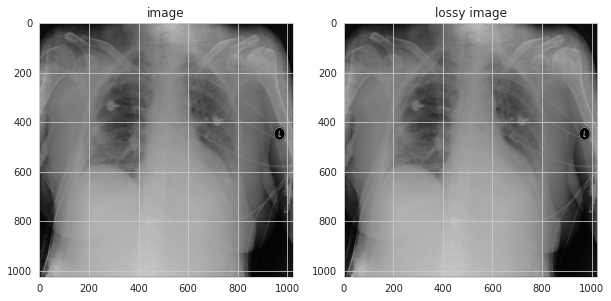

In [106]:
# Convert image to Numpy array
import tensorflow_io as tfio

image_bytes = tf.io.read_file(filenames[1])

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [157]:
IMAGE_SIZE = 224
# x0 = int(labels[1][0] * 1024 / IMAGE_SIZE) # Scale the BBox
# y0 = int(labels[1][1] * 1024 / IMAGE_SIZE)

# x1 = int((labels[1][0] + labels[1][2]) * 1024 / IMAGE_SIZE)
# y1 = int((labels[1][1] + labels[1][3]) * 1024 / IMAGE_SIZE)

x0 = labels[1][0]  # Scale the BBox
y0 = labels[1][1]

x1 = labels[1][2] 
y1 = labels[1][3] 

print(f"x0:{labels[1][0]} y0:{labels[1][1]} x1:{labels[1][2]} y1:{labels[1][3]}")
print(f"x0:{x0} y0:{y0} x1:{x1} y1:{y1}")

x0:225.0 y0:415.0 x1:98.0 y1:101.0
x0:225.0 y0:415.0 x1:98.0 y1:101.0


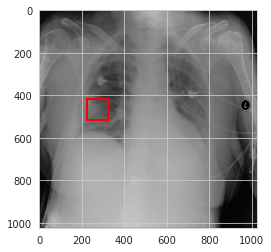

In [158]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(np.squeeze(image.numpy()), cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1, y1, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [107]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  #Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  # image = tf.image.decode_dicom_image(image, channels=3)
  image = tfio.image.decode_dicom_image(image, dtype=tf.float32)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 1000+ images in on go... they all might not fit into memory.

So that's why we do about 32(this is batch size) images at a time (you can manually adjust the batch size if need to be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`.

In [108]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, 
  processes the iamge and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [109]:
# Demo of the above 
get_image_label(X[42], tf.constant(y[42]))

(<tf.Tensor: shape=(1, 224, 224, 1), dtype=float32, numpy=
 array([[[[1.76331635e+02],
          [1.73556122e+02],
          [1.67801010e+02],
          ...,
          [1.23571518e+02],
          [1.27219330e+02],
          [1.29714569e+02]],
 
         [[1.62428558e+02],
          [1.54596939e+02],
          [1.52214294e+02],
          ...,
          [1.04954140e+02],
          [1.10500046e+02],
          [1.09291046e+02]],
 
         [[1.49785706e+02],
          [1.42408157e+02],
          [1.36352036e+02],
          ...,
          [7.97143250e+01],
          [8.42398148e+01],
          [8.29742966e+01]],
 
         ...,
 
         [[2.55000000e+02],
          [2.55000000e+02],
          [2.25571335e+02],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],
 
         [[2.55000000e+02],
          [2.55000000e+02],
          [2.24030655e+02],
          ...,
          [1.57141113e+00],
          [1.27532333e-01],
          [0.00000000e+00]

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all our data `(x & y)` into batches!

In [110]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))   

    # Shuffling pathnames and labels before mapping image processor fucntion is faster then shuffle
    data = data.shuffle(buffer_size=len(X))    

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)   

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)     
    return data_batch



In [111]:
# Create training and validation data batches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [112]:
# Check out the different attribute of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, None, 224, 224, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, None, 224, 224, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be little hard to understand/comprehend, let's visualize the data

In [179]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    #Diplay an image
    plt.imshow(np.squeeze(images[i]), cmap='gray' )
    # Add the image label as the title
    plt.title(i)

    # Turn the gird lines off
    plt.axis("off")

In [172]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

In [182]:
print(labels[9])

[638.0, 535.0, 166.0, 145.0]


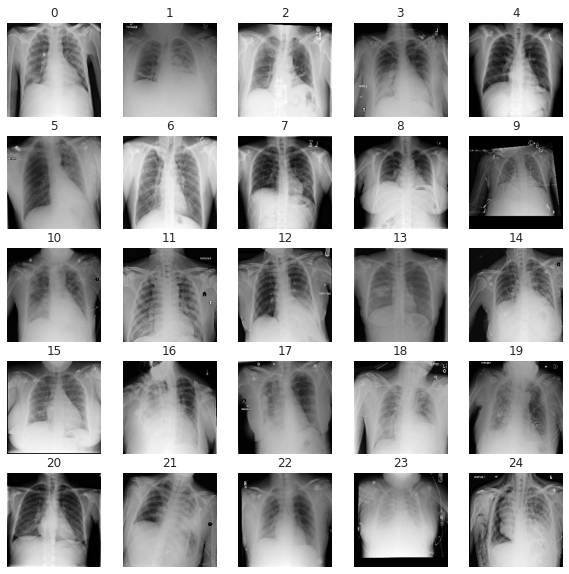

In [180]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

In [129]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())

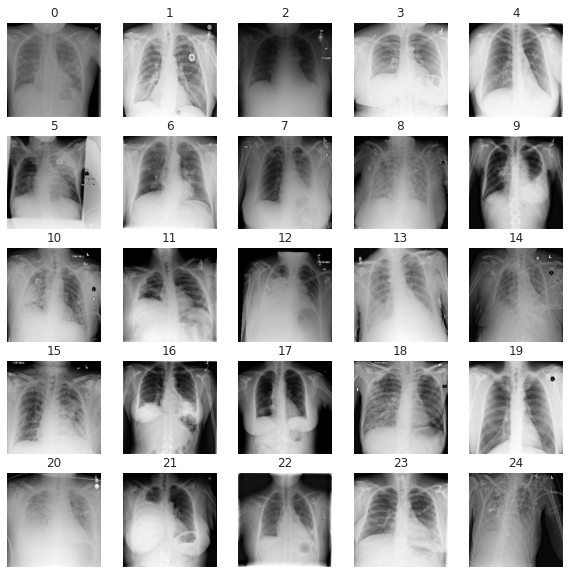

In [130]:
show_25_images(val_images, val_labels)

## Building the model

Before we build a model, there are few things we need to define:

* The input shape (our images shape, in the form of Tensors) to out model.
* The output shape (4) of our models.
* The URL of the model we want to use from the TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4

In [205]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, None] # batch, height, widhth, color channelsl

# Setup output shape of our model
OUTPUT_SHAPE = 4

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"# @param ["https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"]



Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as paramters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model(tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [215]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation='softmax') # Layer 2 (output layer)
  ])

 # Compiler the model
  model. compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

### Initialize the model and print summary

In [216]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   multiple                  4363712   
_________________________________________________________________
dense_7 (Dense)              multiple                  7172      
Total params: 4,370,884
Trainable params: 7,172
Non-trainable params: 4,363,712
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training fro too long.

### TensorBoard Callback

To setpu a TensorBoard Callback, we need to do 3 things
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models traing logs with the `%tensorboard` magic function (we'll do this after model training).

In [209]:
# Load TensorBoard notebook extension

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [210]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Pneumonia Detection/logs",
                        # Make it so that logs get tracked wheneer we run an expriment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Early Stopping Callback

Early stopping helps stop out model from overfitting by stopping training if a certion evaluation metris stops improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [211]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [212]:
NUM_EPOCHS = 100 #@param{type:"slider", min:10, max:100, step:10}

In [202]:
# Check to make sure we're still running on a GPU

print("GPU", "available (YESSSS!!!") if tf.config.list_physical_devices("GPU") else "not available"

GPU available (YESSSS!!!


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [217]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callback we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model
  


In [218]:
# Fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Epoch 1/100


ValueError: ignored